# A chord Recognition algorithm using Harmonic pitch Chord Profilng and Neural Network

The following notebook more or less reproduce the framework described in the following paper:
https://pdfs.semanticscholar.org/155e/64c0411fb58f87d2626ce9ef1417efd26f85.pdf

First things first, the required packges

In [41]:
%matplotlib inline
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import scipy as sp
from scipy.io.wavfile import read
from glob import glob
import os
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [30]:
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import History, Callback, ModelCheckpoint, EarlyStopping
from keras.utils import print_summary 
from keras.regularizers import L1L2
from keras.optimizers import SGD, Adam

I then defined a preprocessing function to compute the HPCP as described in the paper and add some useful metadata like the instrument (This is useful later to evaluate the ability of such an algorithm to recognize chords from a new instrument or a different recording setting of the same one). 
One thing I found unclear in the paper, is that since they use an fft_size of 16384 samples, which windows to select to represent each audio snippet. Therefore, I choose to include each of the consective windows as a separate sample for my dataset. However, since some samples were played melodically, this method might have some drawbacks onthe performance. One could also think of averaging them (which would reduce the sample size obviously).

In [22]:
def preprocessing(rate, data, fft_size, label, instrument):
    """
    Convert the input audio sampled at the input rate
    to a list of HPCP vectors computed using the input fft_size
    (effectively outputing int(len(data)/fft_size)) HPCP vectors
    """
    output_samples = []
    for i in range(int(len(data)/fft_size)):
        ###Computing the DFT by taking a fragment of the audio 
        dft = np.fft.fft(data[fft_size*i:fft_size*(i+1)])
        ### Computiong the Harmonic pitch class profile
        HPCP = []
        f_ref = 130.80
        M = [round(12*np.log2(rate*l/(fft_size*f_ref))) %12 if l > 0 else -1 for l in range(int(fft_size/2))]
        M = np.array(M)
        for p in range(12):
            val = np.sum((np.absolute(dft[:int(fft_size/2)])**2)* (M == p).astype(int) )
            HPCP.append(val)
        HPCP = [x/sum(HPCP) for x in HPCP]
        output_sample = HPCP + [i, instrument, label]
        output_samples.append(output_sample)
     
    return output_samples
    

In [56]:
labels_dict = {
    'a':0,
    'am':1,
    'bm':2,
    'c':3,
    'd':4,
    'dm':5,
    'e':6,
    'em':7,
    'f':8,
    'g':9
}
samples = []
fft_size = 16384
clean_guitar_chords = glob('../data/Guitar_Only/*/*')
for chord in clean_guitar_chords:
    label = labels_dict[chord.split('\\')[-2]]
    instrument = 'Guitar'
    rate, data = read(chord)
    samples_temp = preprocessing(rate, data, fft_size, label, instrument)
    samples = samples + samples_temp

other_instr_chords = glob('../data/Other_Instruments/*/*/*')
for chord in other_instr_chords:
    try:
        label = labels_dict[chord.split('\\')[-2]]
        instrument = chord.split('\\')[-3] if chord.split('\\')[-3] != 'Guitar' else 'Guitar_Noisy'
        rate, data = read(chord)
        samples_temp = preprocessing(rate, data, fft_size, label, instrument)
        samples = samples + samples_temp
    except:
        pass

C:\Users\franck\Anaconda3\envs\tensorflow\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [57]:
columns = ['{}'.format(x) for x in range(12)] +['step', 'instrument', 'label']
df = pd.DataFrame(samples, columns=columns)
df.head()


,0,1,2,3,4,5,6,7,8,9,10,11,step,instrument,label
0,0.005290,0.106823,0.008569,0.013816,0.411795,0.015362,0.036798,0.014543,0.009410,0.364362,0.009016,0.004217,0,Guitar,0
1,0.006705,0.127006,0.008682,0.015580,0.351349,0.007606,0.001009,0.001746,0.008590,0.446242,0.017245,0.008242,1,Guitar,0
2,0.001034,0.041798,0.003427,0.004157,0.412305,0.013483,0.001393,0.001994,0.003698,0.509518,0.003990,0.003201,2,Guitar,0
3,0.003055,0.125677,0.011613,0.008409,0.408539,0.004442,0.014844,0.009215,0.006436,0.389792,0.006976,0.011002,0,Guitar,0
4,0.002733,0.099840,0.013896,0.012738,0.155637,0.010405,0.006699,0.007023,0.018963,0.627339,0.014537,0.030191,1,Guitar,0


In [58]:
"""
df.to_csv('../data/processed.csv', index=False)
"""

"\ndf.to_csv('../data/processed.csv', index=False)\n"

As they did in the paper, I choose to use a mixture of of clean and noisy guitar samples as the training set and the rest of the guitr samples + all the other instruments as a test set. I also took a subset of the test set to use it as validation for the early stoppingin Keras

In [59]:
df_guitar = df[['Guitar' in x for x in  df['instrument']]]
df_not_guitar = df[['Guitar' not in x for x in  df['instrument']]]
X_guitar = df_guitar[['{}'.format(x) for x in range(12)]]
Y_guitar = df_guitar[['step', 'instrument', 'label']]
X_not_guitar = df_not_guitar[['{}'.format(x) for x in range(12)]]
Y_not_guitar = df_not_guitar[['step', 'instrument', 'label']]


X_train, X_test, Y_train, Y_test = train_test_split(X_guitar, Y_guitar, stratify=Y_guitar['label'])

#add all the other instruments to the test set
X_test = pd.concat([X_test, X_not_guitar])
Y_test = pd.concat([Y_test, Y_not_guitar])

#Create a validation set that is going to be used for early stopping
X_test_final, X_val, Y_test_final, Y_val = train_test_split(X_test, Y_test, stratify=Y_test['instrument'])

#formatting the output vector for keras
y_train = np_utils.to_categorical(Y_train['label'])
y_test_final = np_utils.to_categorical(Y_test_final['label'])
y_val = np_utils.to_categorical(Y_val['label'])


Finally I created the model in Keras, adding one additionnal hidden layer to the architechture presented in the model because I noticed that their artitechture was not suffering from overfitting so I tried to increase the model capacitiy to see if that would improve performance

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 35)                455       
_________________________________________________________________
dense_25 (Dense)             (None, 35)                1260      
_________________________________________________________________
dense_26 (Dense)             (None, 10)                360       
Total params: 2,075
Trainable params: 2,075
Non-trainable params: 0
_________________________________________________________________
None
Train on 7555 samples, validate on 825 samples
Epoch 1/200
 - 9s - loss: 2.1554 - acc: 0.3958 - val_loss: 1.9801 - val_acc: 0.5236
Epoch 2/200
 - 8s - loss: 1.4898 - acc: 0.6593 - val_loss: 1.1750 - val_acc: 0.7261
Epoch 3/200
 - 8s - loss: 0.8136 - acc: 0.7825 - val_loss: 0.7425 - val_acc: 0.8012
Epoch 4/200
 - 8s - loss: 0.5376 - acc: 0.8453 - val_loss: 0.5738 - val_acc: 0.8448
Epoch 5/200
 - 8

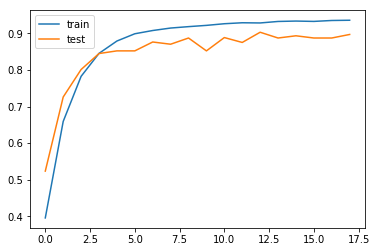

In [60]:
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(35, input_shape=(X_train.shape[1],), activation='relu'))
    model.add(Dense(35, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    sgd = SGD(lr=0.001, momentum=0.25, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    print(model.summary())
    return model

#history = LossHistory()
history = History()
filepath = '../data/external/weights_best.hdf5'
model = KerasClassifier(build_fn=create_model, epochs=200, batch_size=1, verbose=2, )#, validation_data=(X_test, y_test))
earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=5, \
                          verbose=1, mode='auto')
model.fit(X_train.values, y_train, callbacks = [history, earlystop], validation_data=(X_val.values, y_val))# model__validation_split=0.3)
# plot history
plt.plot(history.history['acc'], label='train')
##plt.plot(history.losses, label='train', alpha=.5)
plt.plot(history.history['val_acc'], label='test')
#plt.plot(history.val_losses, label='test', alpha=.5)
plt.legend()
plt.show()

The last step is isualizing the confusion matrix for each instrument to see how our chord recognition algoritm trained on a mixture of clean and noisy guitar sample perform accross multiple instruments

In [61]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Clean Guitar

Confusion matrix, without normalization
[[146   5   0   0   0   0   0   0   0   0]
 [  5 171   0   1   0   0   0   1   5   0]
 [  0   0 141   0   1   0   0   0   0   1]
 [  0   0   0 249   0   0   0   1   4   0]
 [  1   0   0   0 167  15   0   0   0   0]
 [  0   0   0   0  13 145   0   0   2   1]
 [  0   0   3   0   0   0 191   2   0   0]
 [  0   0   1   0   0   0   3 154   0   1]
 [  0   3   0   8   0   0   0   0 195   0]
 [  0   0   0   0   0   0   0   1   0 190]]


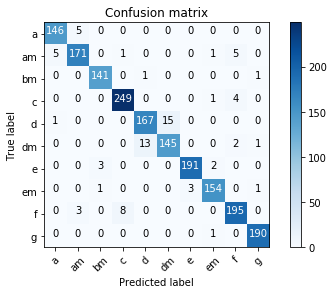

In [62]:
Y_clean_guitar = Y_test_final[Y_test_final['instrument'] == 'Guitar']
X_clean_guitar = X_test_final[Y_test_final['instrument'] == 'Guitar']
y_clean_guitar_hat = model.predict(X_clean_guitar)
cm = confusion_matrix(Y_clean_guitar['label'], y_clean_guitar_hat)
plot_confusion_matrix(cm, classes=labels_dict.keys(),
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

We can see that the classifier often confuses a D for a Dm. This is interesting because they onl vary by the 3rd that goes from major to minor ( F# to F). This is understandable given thefeatures that we use (th HPCP). Howeer, it goes to show that this is probably not the way human recognize chords since major and minor color in chord are rather easily distinguishable for musicians

### Noisy Guitar

Confusion matrix, without normalization
[[9 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 4 2 0 0 0 0]
 [0 0 0 0 2 2 0 0 0 0]
 [0 0 0 0 0 0 7 0 0 0]
 [0 0 0 0 0 0 0 7 0 0]
 [0 0 0 0 0 0 0 0 9 0]
 [0 0 0 0 0 0 0 0 0 5]]


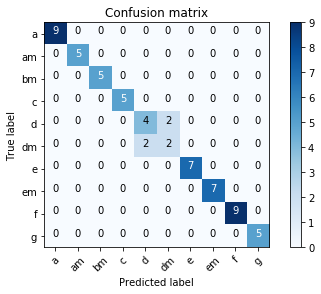

In [64]:
Y_noisy_guitar = Y_test_final[Y_test_final['instrument'] == 'Guitar_Noisy']
X_noisy_guitar = X_test_final[Y_test_final['instrument'] == 'Guitar_Noisy']
y_noisy_guitar_hat = model.predict(X_noisy_guitar)
cm = confusion_matrix(Y_noisy_guitar['label'], y_noisy_guitar_hat)
plot_confusion_matrix(cm, classes=labels_dict.keys(),
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

The sample size is rather low for this instrument (probaby because of how I divided my dataset but we can see the same behaviour as for the clean guitar

### Accordion

Confusion matrix, without normalization
[[34  0  0  0  0  0  0  0  0  0]
 [ 1  4  0 29  0  0  0  0  1  0]
 [ 0  0 22  0  9  0  0  0  0  0]
 [ 0  0  0 19  0  0  0  0  0  2]
 [ 0  0  0  0 31  0  0  0  0  0]
 [ 0  0  0  0  0 10  0  0 23  0]
 [ 0  0  0  0  0  0 32  0  0  0]
 [ 0  0 10  0  0  0  2 12  0  6]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0 16  0  1  3  0  0  0 11]]


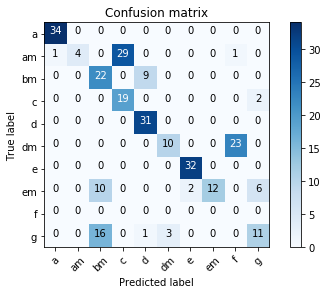

In [65]:
Y_accordion = Y_test_final[Y_test_final['instrument'] == 'Accordion']
X_accordion = X_test_final[Y_test_final['instrument'] == 'Accordion']
y_accordion_hat = model.predict(X_accordion)
cm = confusion_matrix(Y_accordion['label'], y_accordion_hat)
plot_confusion_matrix(cm, classes=labels_dict.keys(),
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

We can directly notice that the performance is poorer for this instrument. However, the mistake make sense because they usually occur occur for chords that differe by one note (Dm vs F or G vs Bm). The algorithm is having a hard time distinguishing them for new instrument because of the different spectral distribution.

### Piano

Confusion matrix, without normalization
[[27  0  0  0  0  0  0  0  1  0]
 [ 0 16  0  6  0  0  0  0  2  0]
 [ 0  0 16  0  0  0  0  0  0  0]
 [ 0  1  0 17  0  0  0  2  0  0]
 [ 0  0  0  0 17  0  0  0  0  0]
 [ 0  0  0  0  0  7  0  0  5  0]
 [ 0  0  0  0  0  0 14  0  0  0]
 [ 0  0  0  0  0  0  0 11  0  3]
 [ 0  0  0  0  0  1  0  0 14  0]
 [ 0  0  2  1  0  1  0  0  0  8]]


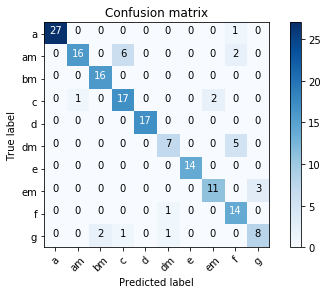

In [66]:
Y_piano = Y_test_final[Y_test_final['instrument'] == 'Piano']
X_piano = X_test_final[Y_test_final['instrument'] == 'Piano']
y_piano_hat = model.predict(X_piano)
cm = confusion_matrix(Y_piano['label'], y_piano_hat)
plot_confusion_matrix(cm, classes=labels_dict.keys(),
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

We can see that the algorithm performs better than on the accordion

### Violin

Confusion matrix, without normalization
[[10  0  0  0  0  0  0  0  0  0]
 [ 1  3  0  3  0  0  0  0  4  0]
 [ 0  0 10  0  6  0  0  0  0  3]
 [ 0  0  0  8  0  0  0  1  0  0]
 [ 0  0  0  0 15  0  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  3  0]
 [ 0  0  0  0  0  0  8  0  0  0]
 [ 0  0  0  0  0  0  0 11  0  0]
 [ 0  6  0  0  0  0  0  0  4  0]
 [ 0  0  0  0  4  0  0  0  0 26]]


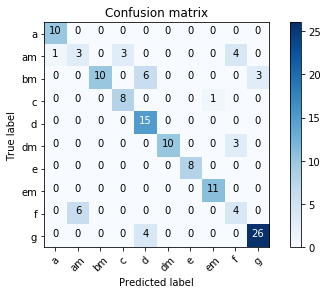

In [67]:
Y_violin = Y_test_final[Y_test_final['instrument'] == 'Violin']
X_violin = X_test_final[Y_test_final['instrument'] == 'Violin']
y_violin_hat = model.predict(X_violin)
cm = confusion_matrix(Y_violin['label'], y_violin_hat)
plot_confusion_matrix(cm, classes=labels_dict.keys(),
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

Finally, we can see that the performance for the violin is somewhat inbetween that for the piano and the accordion.